In [61]:
import spkit as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import mne
from copy import deepcopy
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from autoreject import Ransac
from mne.preprocessing import annotate_amplitude
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

In [62]:
def Load_Raw(path, sfreq = 300, plot_raw = False):
    data = np.array(pd.read_csv(path, skiprows=2))

    data = np.delete(data, [0, 1, -1, -3, -4], axis=1)
    #data = np.delete(data, [0, 1, -1], axis=1)


    #ch_name = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1', 'ECG']
    channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'ECG']
    #ch_name = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1']

    X = deepcopy(data)
    X = deepcopy(X[10000:-10000])

    sfreq = 300
    info = mne.create_info(channel_names, sfreq, ch_types=['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg'])
    raw = mne.io.RawArray(X.T, info);
    raw.set_montage('standard_1020')

    if(plot_raw):
        raw.plot(scalings='auto');

    return raw


In [63]:
def Artifact_Correction(raw, plot_source=False):
    ica = ICA(n_components=21, max_iter="auto", random_state=97)
    ica.fit(raw)

    explained_var_ratio = ica.get_explained_variance_ratio(raw)
    for channel_type, ratio in explained_var_ratio.items():
        print(
            f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
        )

    raw.load_data()
    if(plot_source):
        ica.plot_sources(raw, show_scrollbars=False);
    
    n_max_ecg = 15  
    ecg_epochs = create_ecg_epochs(raw, tmin=-.3, tmax=.3)
    #ecg_epochs.decimate(5).apply_baseline((None, None))
    ecg_inds, scores_ecg = ica.find_bads_ecg(ecg_epochs, threshold='auto', method='correlation')
    print('Found %d ECG component(s)' % (len(ecg_inds),))
    ica.exclude += ecg_inds[:n_max_ecg]
    ica.plot_scores(scores_ecg, exclude=ecg_inds, title='ECG scores');


    print(ica.exclude)
    ica.apply(raw, exclude=ica.exclude)

    bad_segments = annotate_amplitude(raw, peak=5, flat=0.5, min_duration=0.5)
    raw.set_annotations(bad_segments[0])
    
    epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True, overlap= 1)

    return epochs

In [64]:
def Reject_Bad_Epochs(epochs):
    ar = AutoReject()
    new_epochs = ar.fit_transform(epochs, random)
    return new_epochs

In [65]:
def Bipolar(new_epochs):
    anode = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']
    cathode = ['F3', 'F8', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']
    bipolar_data = mne.set_bipolar_reference(new_epochs[0], anode, cathode);
    
    return bipolar_data

In [66]:
mne.set_config("MNE_USE_CUDA", "True")
mne.cuda.init_cuda()

C:\Users\admin\AppData\Local\Temp\ipykernel_18704\1989074984.py:2: RuntimeWarning: module cupy not found, CUDA not enabled


In [67]:
path = r"D:\Clean Data\TLE\FarahmandianHakime\samples.csv"
name = 'FarahmandianHakime'
raw = Load_Raw(path);

Creating RawArray with float64 data, n_channels=22, n_times=1743996
    Range : 0 ... 1743995 =      0.000 ...  5813.317 secs
Ready.


Fitting ICA to data using 21 channels (please be patient, this may take a while)


C:\Users\admin\AppData\Local\Temp\ipykernel_18704\2675175726.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.


Selecting by number: 21 components
Fitting ICA took 23.4s.
Fraction of eeg variance explained by all components: 1.0
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 3000 samples (10.000 s)

Number of ECG events detected : 7558 (average pulse 78 / min.)
Not setting metadata
7558 matching events found
No baseline correction applied
Using data from preloaded Raw for 7558 events and 181 original time points ...
0 bad epochs dropped
Found 1 ECG component(s)


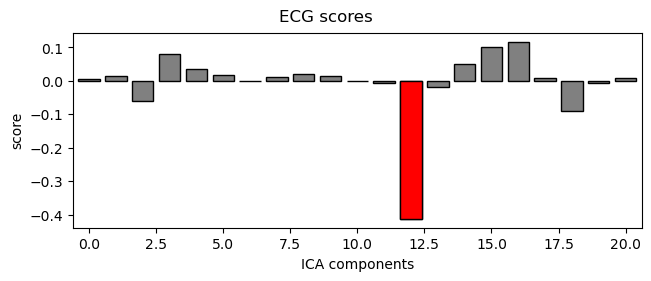

[12]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component
    Projecting back using 21 PCA components
Finding segments below or above PTP threshold.
Not setting metadata
645 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 645 events and 3000 original time points ...
42 bad epochs dropped


In [68]:
epochs = Artifact_Correction(raw)

In [69]:
new_epochs = Reject_Bad_Epochs(epochs)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/603 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/603 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/603 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/603 [00:00<?,       ?it/s]

c:\Users\admin\anaconda3\lib\site-packages\mne\bem.py:1134: RuntimeWarning: Mean of empty slice.
c:\Users\admin\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\admin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
c:\Users\admin\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/603 [00:00<?,       ?it/s]

Dropped 204 epochs: 5, 9, 86, 91, 92, 95, 108, 116, 118, 127, 130, 133, 138, 140, 144, 145, 149, 150, 151, 153, 154, 155, 161, 162, 163, 166, 167, 168, 170, 175, 176, 177, 178, 179, 182, 187, 188, 189, 193, 195, 196, 198, 199, 201, 202, 204, 205, 206, 211, 214, 218, 219, 220, 222, 226, 228, 229, 230, 234, 236, 237, 239, 242, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257, 258, 260, 261, 262, 264, 265, 266, 268, 269, 270, 271, 273, 275, 276, 277, 278, 280, 282, 283, 288, 289, 294, 297, 298, 300, 310, 311, 324, 328, 332, 337, 345, 346, 350, 351, 352, 355, 357, 358, 364, 370, 375, 379, 389, 394, 396, 397, 398, 399, 403, 404, 406, 408, 409, 412, 416, 419, 420, 428, 431, 434, 436, 437, 439, 440, 443, 444, 445, 446, 447, 449, 452, 456, 457, 459, 460, 461, 462, 464, 466, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 497, 498, 500, 501, 502, 504, 505, 507, 508, 509, 510, 513, 514, 515, 516, 517, 518

In [70]:
bipolar_data = Bipolar(new_epochs)

EEG channel type selected for re-referencing
Not setting metadata
399 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
Fp1-F3, Fp2-F8, F3-C3, F4-C4, C3-P3, C4-P4, P3-O1, P4-O2, F7-T3, F8-T4, T3-T5, T4-T6, T5-O1, T6-O2


In [71]:
bipolar_data.save(name + ".fif", overwrite=True)
#bipolar_data_from_file = mne.read_epochs("test.fif", preload=False)

C:\Users\admin\AppData\Local\Temp\ipykernel_18704\3222617806.py:1: RuntimeWarning: This filename (FarahmandianHakime.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


In [72]:
"""
#bipolar_data = mne.set_bipolar_reference(new_epochs[0], anode, cathode);
bipolar_data = bipolar_data.get_data(picks='eeg')
#scaler = mne.decoding.Scaler(info = info, scalings=None)


#bipolar_data = bipolar_data.reshape(-1, 3000, 20)
pre = bipolar_data[141]
scaler = StandardScaler()


post = scaler.fit_transform(pre)

normals = []
scaler = StandardScaler()
for idx in range(len(bipolar_data)):
    normals.append(scaler.fit_transform(bipolar_data[idx]))
normals = np.array(normals)


normals.shape
"""

"\n#bipolar_data = mne.set_bipolar_reference(new_epochs[0], anode, cathode);\nbipolar_data = bipolar_data.get_data(picks='eeg')\n#scaler = mne.decoding.Scaler(info = info, scalings=None)\n\n\n#bipolar_data = bipolar_data.reshape(-1, 3000, 20)\npre = bipolar_data[141]\nscaler = StandardScaler()\n\n\npost = scaler.fit_transform(pre)\n\nnormals = []\nscaler = StandardScaler()\nfor idx in range(len(bipolar_data)):\n    normals.append(scaler.fit_transform(bipolar_data[idx]))\nnormals = np.array(normals)\n\n\nnormals.shape\n"